# 04 - Feed Forward Approach

* After getting 4th place out of 9, I decided to try a simpler strategy
* Input: one detector plane, output: the next detector plane
* Each track has 24 training samples
* Let's try it out and see what happens

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout, ReLU, GRU, TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from jlab import load_test_data, get_test_detector_plane

## Load up and prep the datasets

In [88]:
data = pd.read_csv('MLchallenge2_training.csv')

## Construct the training data and targets

* For each track
  * For each detector between 1-24
    * Extract x, y, z, px, py, pz for detectors 1-24
    * Add detector ID
    * Append to X_train
    * Append the next detector's x, y, px, py, pz to y_train

### Training Dataset

In [90]:
def extract_X_y(df):
    N_TRACKS = len(df)

    X_train_single = np.ndarray(shape=(N_TRACKS * 22, 7))
    y_train_single = np.ndarray(shape=(N_TRACKS * 22, 5))
    for ix in range(0, N_TRACKS):
        alldetvals = df.iloc[ix]
        for twix in range(2, N_DETECTORS-1):
            detvals = list(alldetvals[[f"{kin}{twix}" for kin in ["x", "y", "z", "px", "py", "pz"]]])
            detvals.append(twix)
            detvals = np.array(detvals)
            X_train_single[(22*ix + twix - 2)] = detvals
            nextdetvals = np.array(alldetvals[[f"{kin}{twix + 1}" for kin in ["x", "y", "px", "py", "pz"]]])
            y_train_single[(22*ix + twix - 2)] = nextdetvals
            
    return X_train_single, y_train_single

In [89]:
X_train, y_train = extract_X_y(data.loc[0:5000])

In [91]:
X_test, y_test = extract_X_y(data.loc[5000:6000])

In [92]:
X_train[50]

array([-6.70072e+00, -3.41014e+01,  2.37639e+02,  1.07044e-03,
       -5.47939e-02,  9.48410e-01,  8.00000e+00])

In [93]:
y_train[50]

array([-6.69948e+00, -3.42240e+01,  2.95884e-05, -5.46881e-02,
        9.48391e-01])

In [110]:
from sklearn.ensemble import RandomForestRegressor

In [111]:
rfr = RandomForestRegressor(n_estimators=1000)

In [112]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [113]:
y_pred = rfr.predict(X_test)

In [115]:
from sklearn.metrics import mean_squared_error

In [116]:
mse = mean_squared_error(y_test, y_pred)

In [117]:
mse

0.5246346810425874

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LeakyReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [106]:
def lrelu(x):
    return LeakyReLU()(x)


def dense_model(dense_units=100, dropout_rate=0.25):
    """Model definition.
    
    Parameters
    ----------
    dense_units : int
    dropout_rate : float
    
    Returns
    -------
    tensorflow.keras.models.Sequential
    
    """
    
    model = Sequential()
    
    model.add(Dense(500, activation=lrelu,
                  input_dim=7))
    model.add(Dropout(dropout_rate))
    model.add(Dense(100, activation=lrelu))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5))
    
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [107]:
model = dense_model()

In [108]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 500)               4000      
_________________________________________________________________
dropout_18 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 505       
Total params: 54,605
Trainable params: 54,605
Non-trainable params: 0
_________________________________________________________________


In [109]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=5, restore_best_weights=True)
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    callbacks=[es],
    epochs=50,
)

model.save("dense_model.h5")
joblib.dump(history.history, "dense_model.history")

Train on 110022 samples, validate on 22022 samples
Epoch 1/50
110022/110022 [==============================] - 8s 68us/sample - loss: 6.5095 - val_loss: 1.0105
Epoch 2/50
110022/110022 [==============================] - 7s 64us/sample - loss: 2.0344 - val_loss: 0.9027
Epoch 3/50
110022/110022 [==============================] - 7s 64us/sample - loss: 1.9189 - val_loss: 0.7303
Epoch 4/50
110022/110022 [==============================] - 7s 64us/sample - loss: 1.8968 - val_loss: 0.7220
Epoch 5/50
110022/110022 [==============================] - 7s 64us/sample - loss: 1.8854 - val_loss: 0.5414
Epoch 6/50
110022/110022 [==============================] - 7s 64us/sample - loss: 1.8632 - val_loss: 0.5917
Epoch 7/50
110022/110022 [==============================] - 7s 64us/sample - loss: 1.8528 - val_loss: 0.7207
Epoch 8/50
110022/110022 [==============================] - 7s 64us/sample - loss: 1.8675 - val_loss: 1.0031
Epoch 9/50
110022/110022 [==============================] - 7s 64us/sample - 

['dense_model.history']

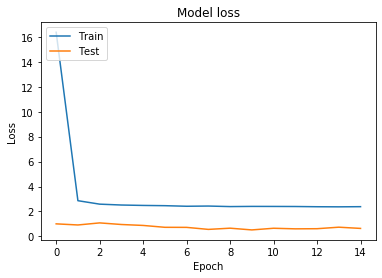

In [101]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()